## Setup Environment

In [5]:
# Install specific libraries
! pip install transformers
! pip install pycaret

In [9]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [ ]:
# # Mount Google Drive - applicable, if working on Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# # Set Working Directory - if working on Google Drive
# %cd /content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection

# # # Set Working Directory - if working on Local Machine
import os
os.chdir("C:\\Users\\nida imran\\Desktop\\Project11_FakeNewsDetection")


## Load Dataset

In [10]:
# Load Dataset
true_data = pd.read_csv('a1_True.csv')
fake_data = pd.read_csv('a2_Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,ETHIOPIAN MUSLIM Monster Deported From U.S. 10...,With a growing number of Muslim refugees and i...,left-news,"Mar 16, 2017",Fake
1,U.S. condemns Russia veto of probe into Syria ...,WASHINGTON (Reuters) - The United States is v...,worldnews,"October 24, 2017",True
2,MEDIA IGNORES TRUMP’S FIRST Record-Breaking Ch...,The Stock Market is setting record after recor...,politics,"Dec 26, 2017",Fake
3,Spain's King condemns Catalan leaders as thous...,BARCELONA (Reuters) - Spain s King Felipe VI o...,worldnews,"October 3, 2017",True
4,"ASPIRATIONS: Young Chinese seize the day, seiz...",(Reuters) - The world is this generation s oys...,worldnews,"October 17, 2017",True


In [11]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1) 
data['label'] = pd.get_dummies(data.Target)['Fake']

In [12]:
# data.head()

,title,text,subject,date,Target,label
0,ETHIOPIAN MUSLIM Monster Deported From U.S. 10...,With a growing number of Muslim refugees and i...,left-news,"Mar 16, 2017",Fake,1
1,U.S. condemns Russia veto of probe into Syria ...,WASHINGTON (Reuters) - The United States is v...,worldnews,"October 24, 2017",True,0
2,MEDIA IGNORES TRUMP’S FIRST Record-Breaking Ch...,The Stock Market is setting record after recor...,politics,"Dec 26, 2017",Fake,1
3,Spain's King condemns Catalan leaders as thous...,BARCELONA (Reuters) - Spain s King Felipe VI o...,worldnews,"October 3, 2017",True,0
4,"ASPIRATIONS: Young Chinese seize the day, seiz...",(Reuters) - The world is this generation s oys...,worldnews,"October 17, 2017",True,0


([<matplotlib.patches.Wedge at 0x1c61965e1c0>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

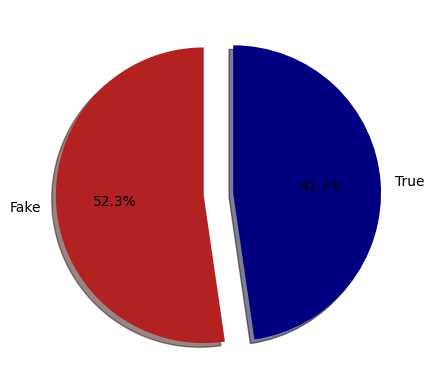

In [13]:
# # Checking if our data is well balanced
# label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
# plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [14]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
from sklearn.model_selection import  train_test_split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [15]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

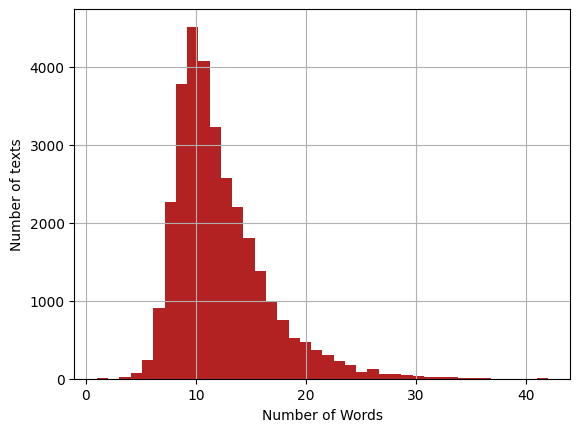

In [16]:
# # Plot histogram of the number of words in train data 'title'
# seq_len = [len(title.split()) for title in train_text]

# pd.Series(seq_len).hist(bins = 40,color='firebrick')
# plt.xlabel('Number of Words')
# plt.ylabel('Number of texts')

In [ ]:
# # BERT Tokeizer Functionality
# sample_data = ["Build fake news model.", 
#                "Using bert."]                                         # sample data
# tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
#                                                     padding=True)     # encode text
# print(tokenized_sample_data)

# # Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [17]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [28]:
import torch
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [30]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [20]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [27]:
import torch.nn as nn
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 2

### Define Train & Evaluate Function

In [31]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

### Model training

In [ ]:
# # Train and predict
# best_valid_loss = float('inf')
# train_losses=[]                   # empty lists to store training and validation loss of each epoch
# valid_losses=[]

# for epoch in range(epochs):     
#     print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
#     train_loss = train()                       # train model
#     valid_loss = evaluate()                    # evaluate model
#     if valid_loss < best_valid_loss:              # save the best model
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'c2_new_model_weights.pt')
#     train_losses.append(train_loss)               # append training and validation loss
#     valid_losses.append(valid_loss)
    
#     print(f'\nTraining Loss: {train_loss:.3f}')
#     print(f'Validation Loss: {valid_loss:.3f}')

### Model performance

In [34]:
# # load weights of best model
# path = 'c2_new_model_weights.pt'
# model.load_state_dict(torch.load(path))

In [36]:
# from sklearn.metrics import classification_report

# with torch.no_grad():
#   preds = model(test_seq, test_mask)
#   preds = preds.detach().cpu().numpy()

# preds = np.argmax(preds, axis = 1)
# print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3212
           1       0.92      0.84      0.88      3523

    accuracy                           0.88      6735
   macro avg       0.88      0.88      0.88      6735
weighted avg       0.88      0.88      0.88      6735



## Fake News Predictions

In [ ]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

In [37]:

from test import response
# print(response.text)
def fakeNewsDetector(unseen_news_text, model, tokenizer):
    # tokenize and encode sequences in the test set
    MAX_LENGHT = 15
    tokens_unseen = tokenizer.batch_encode_plus(
        [unseen_news_text],
        max_length = MAX_LENGHT,
        pad_to_max_length=True,
        truncation=True
    )

    unseen_seq = torch.tensor(tokens_unseen['input_ids'])
    unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

    with torch.no_grad():
      preds = model(unseen_seq, unseen_mask)
      preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis = 1)
    return preds.item()

fakeNewsDetector(response.text, model, tokenizer)

0